In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

import itertools
import matplotlib.pyplot as plt
import numpy as np

from collections import defaultdict
from tqdm import tqdm_notebook as tqdm

In [2]:
class GaussianMixtureDataset(Dataset):
    def __init__(self, num_classes=8, scale=4.0, num_examples=100000, rng=None, seed=0):
        super().__init__()
        np.random.seed(0)
        rng = np.random.RandomState() if rng is None else rng
        rads = np.linspace(0, 2 * np.pi, num_classes, endpoint=False)
        centers = np.stack([scale * np.cos(rads), scale * np.sin(rads)], axis=1)
        samples_per_class = int(np.ceil(num_examples / num_classes))
        data = np.tile(centers, [samples_per_class, 1])[:num_examples]
        data = np.array(data + 0.5 * rng.randn(num_examples, 2)) / np.sqrt(2)
        labels = np.tile(np.arange(num_classes), [samples_per_class])[:num_examples]
        self.data = data.astype('float32')
        self.labels = labels.astype('int64')

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return self.data[idx], self.labels[idx]

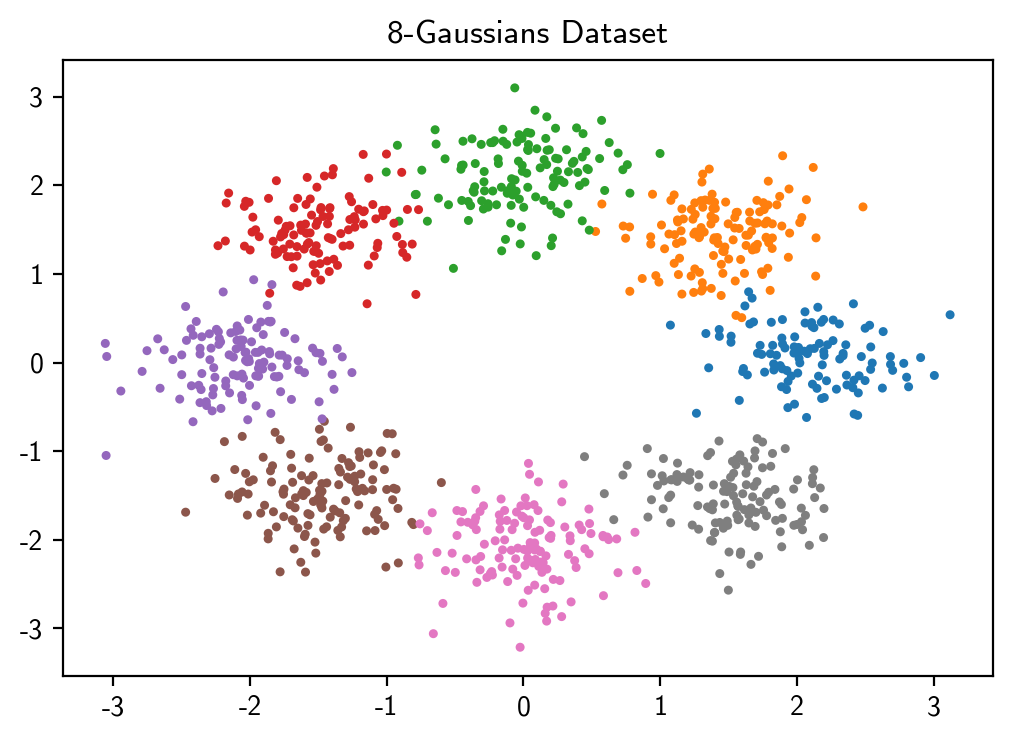

In [10]:
samples, labels = next(iter(DataLoader(GaussianMixtureDataset(seed=0, scale=3), batch_size=1000, shuffle=True)))
fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(samples[:, 0], samples[:, 1], c=['C{}'.format(l) for l in labels], s=5)
ax.set_title('8-Gaussians Dataset');

In [40]:
def gaussian_mixture(scale=4.0, batch_size=100, num_workers=1):
    train_loader = DataLoader(GaussianMixtureDataset(seed=0, scale=scale), batch_size=batch_size, num_workers=num_workers, shuffle=True)
    valid_loader = DataLoader(GaussianMixtureDataset(seed=1, scale=scale), batch_size=batch_size, num_workers=num_workers, shuffle=False)
    return train_loader, valid_loader


def plot_accuracy_loss(accuracies, losses, title='MLP', num_epochs_per_task=5):
    fig, [ax0, ax1] = plt.subplots(1, 2, figsize=(12, 4))
    for task_id, acc in accuracies.items():
        ax0.fill_between(range(len(accuracies[0]) - len(acc), len(accuracies[0])), 0, 100 * np.array(acc), alpha=0.3)
        ax0.plot(range(len(accuracies[0]) - len(acc), len(accuracies[0])), 100 * np.array(acc), label='Task {}'.format(task_id))
    for it in range(0, len(accuracies[0]), num_epochs_per_task):
        ax0.axvline(x=it, color='black', linestyle='dotted')
    ax0.set_xlabel('Epochs')
    ax0.set_ylabel('Accuracy (%)')
    ax0.set_title('{} - Classification Accuracy'.format(title))
    ax0.legend()

    for task_id, loss in losses.items():
        ax1.fill_between(range(len(losses[0]) - len(loss), len(losses[0])), 0, loss, alpha=0.3)
        ax1.plot(range(len(losses[0]) - len(loss), len(losses[0])), loss, label='Task {}'.format(task_id))
    for it in range(0, len(losses[0]), num_epochs_per_task):
        ax1.axvline(x=it, color='black', linestyle='dotted')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('{} - Cross Entropy Loss'.format(title))
    ax1.legend()
    plt.tight_layout()
    
    
def train_mlp(mlp, train_loaders, valid_loaders, optimizer, num_epochs_per_task=5):
    mlp_loss, mlp_acc = defaultdict(list), defaultdict(list)
    for task_id, train_loader in enumerate(train_loaders):
        for epoch in range(num_epochs_per_task):
            mlp.train()
            progress_bar = tqdm(train_loader, desc='Task {} - Train Epoch {:03d}'.format(task_id, epoch), leave=False)
            for batch_id, (images, labels) in enumerate(progress_bar):
                images, labels = images.cuda(), labels.cuda()
                loss = F.cross_entropy(input=mlp(images), target=labels)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                progress_bar.set_postfix({'loss': '{:.3f}'.format(loss.item())})

            mlp.eval()
            for prev_task_id, valid_loader in enumerate(valid_loaders[:task_id + 1]):
                correct, total = 0, 0
                progress_bar = tqdm(valid_loader, desc='Task {} - Test Task {}'.format(task_id, prev_task_id), leave=False)
                for batch_id, (images, labels) in enumerate(progress_bar):
                    images, labels = images.cuda(), labels.cuda()
                    logits = mlp(images)
                    loss = F.cross_entropy(input=logits, target=labels)
                    preds = logits.argmax(dim=1, keepdim=True)
                    correct += preds.eq(labels.view_as(preds)).sum().item()
                    total += len(images)
                    progress_bar.set_postfix({'loss': '{:.3f}'.format(loss.item()), 'accuracy': '{:.3f}'.format(1.0 * correct / total)})

                mlp_loss[prev_task_id].append(loss.item())
                mlp_acc[prev_task_id].append(1.0 * correct / total)
                
    return mlp_loss, mlp_acc

### Standard MLP

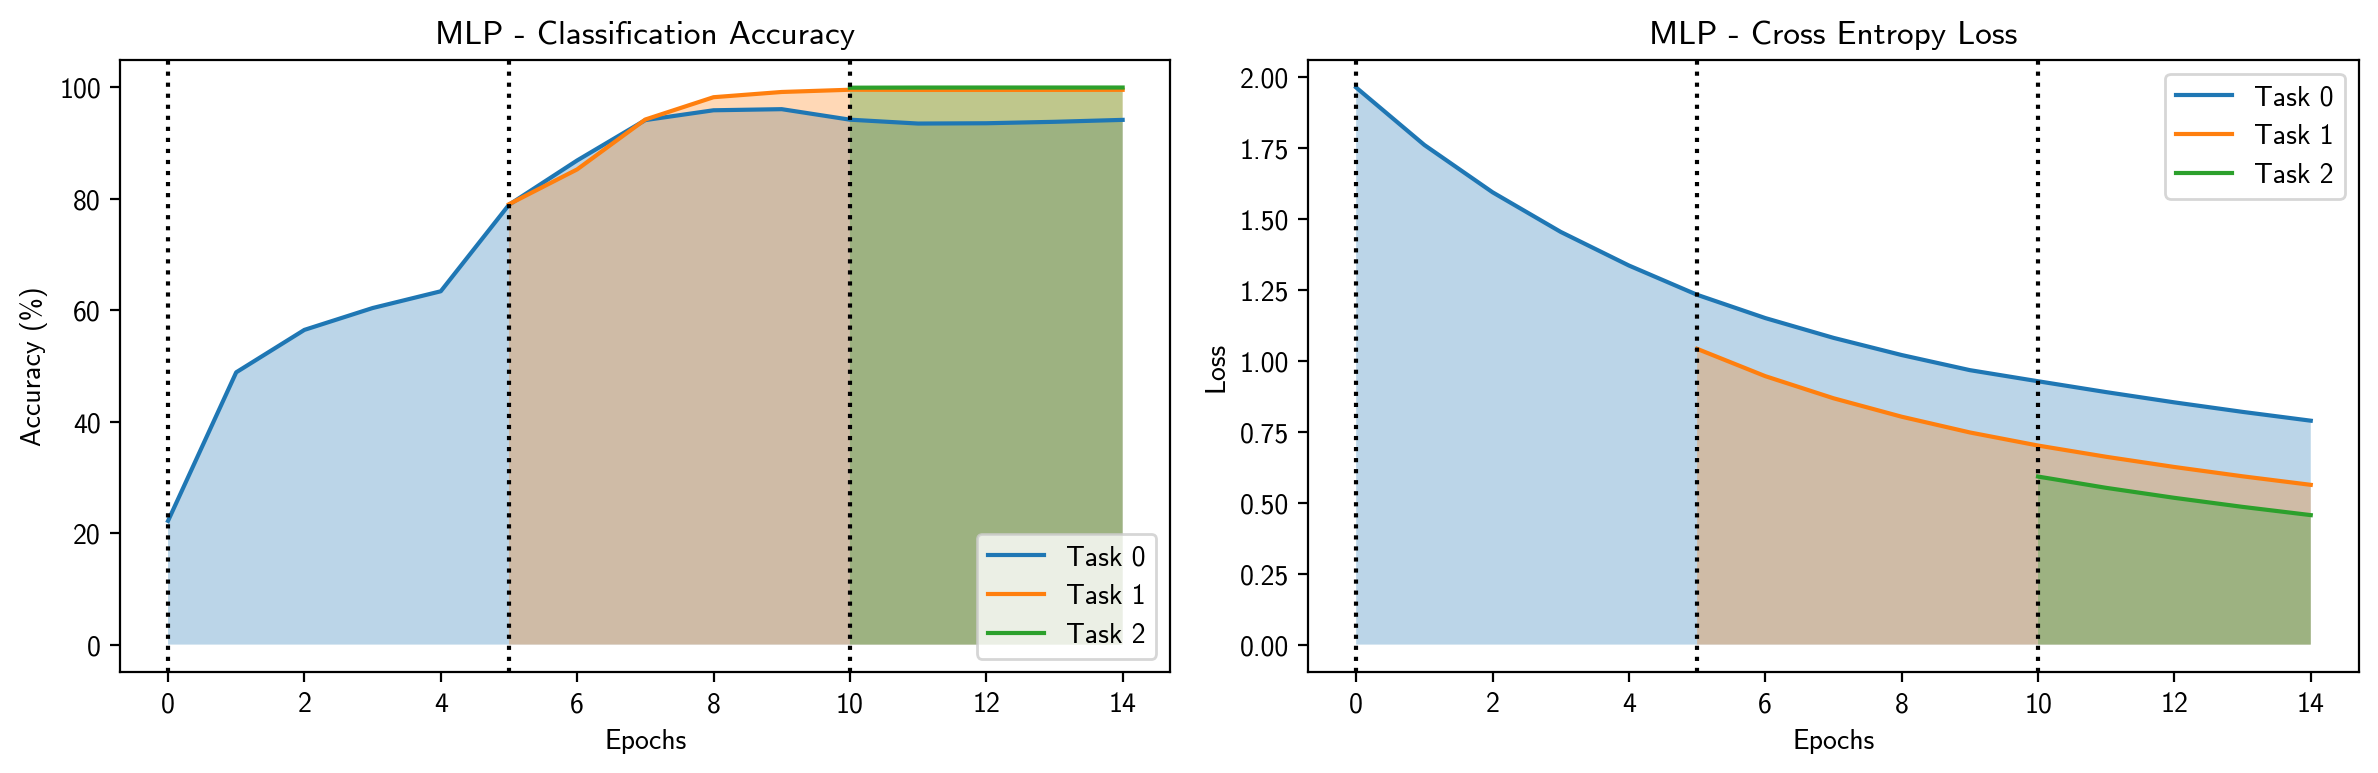

In [61]:
torch.manual_seed(0)
mlp = torch.nn.Sequential(nn.Linear(2, 8)).cuda()
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-4)
train_loaders, valid_loaders = zip(*[gaussian_mixture(scale=scale, batch_size=100) for scale in [3.0, 4.0, 5.0]])
mlp_loss, mlp_acc = train_mlp(mlp, train_loaders, valid_loaders, optimizer)
# torch.save({'mlp_loss': mlp_loss, 'mlp_acc': mlp_acc}, 'mlp_mnist.pt')
plot_accuracy_loss(mlp_acc, mlp_loss, title='MLP')

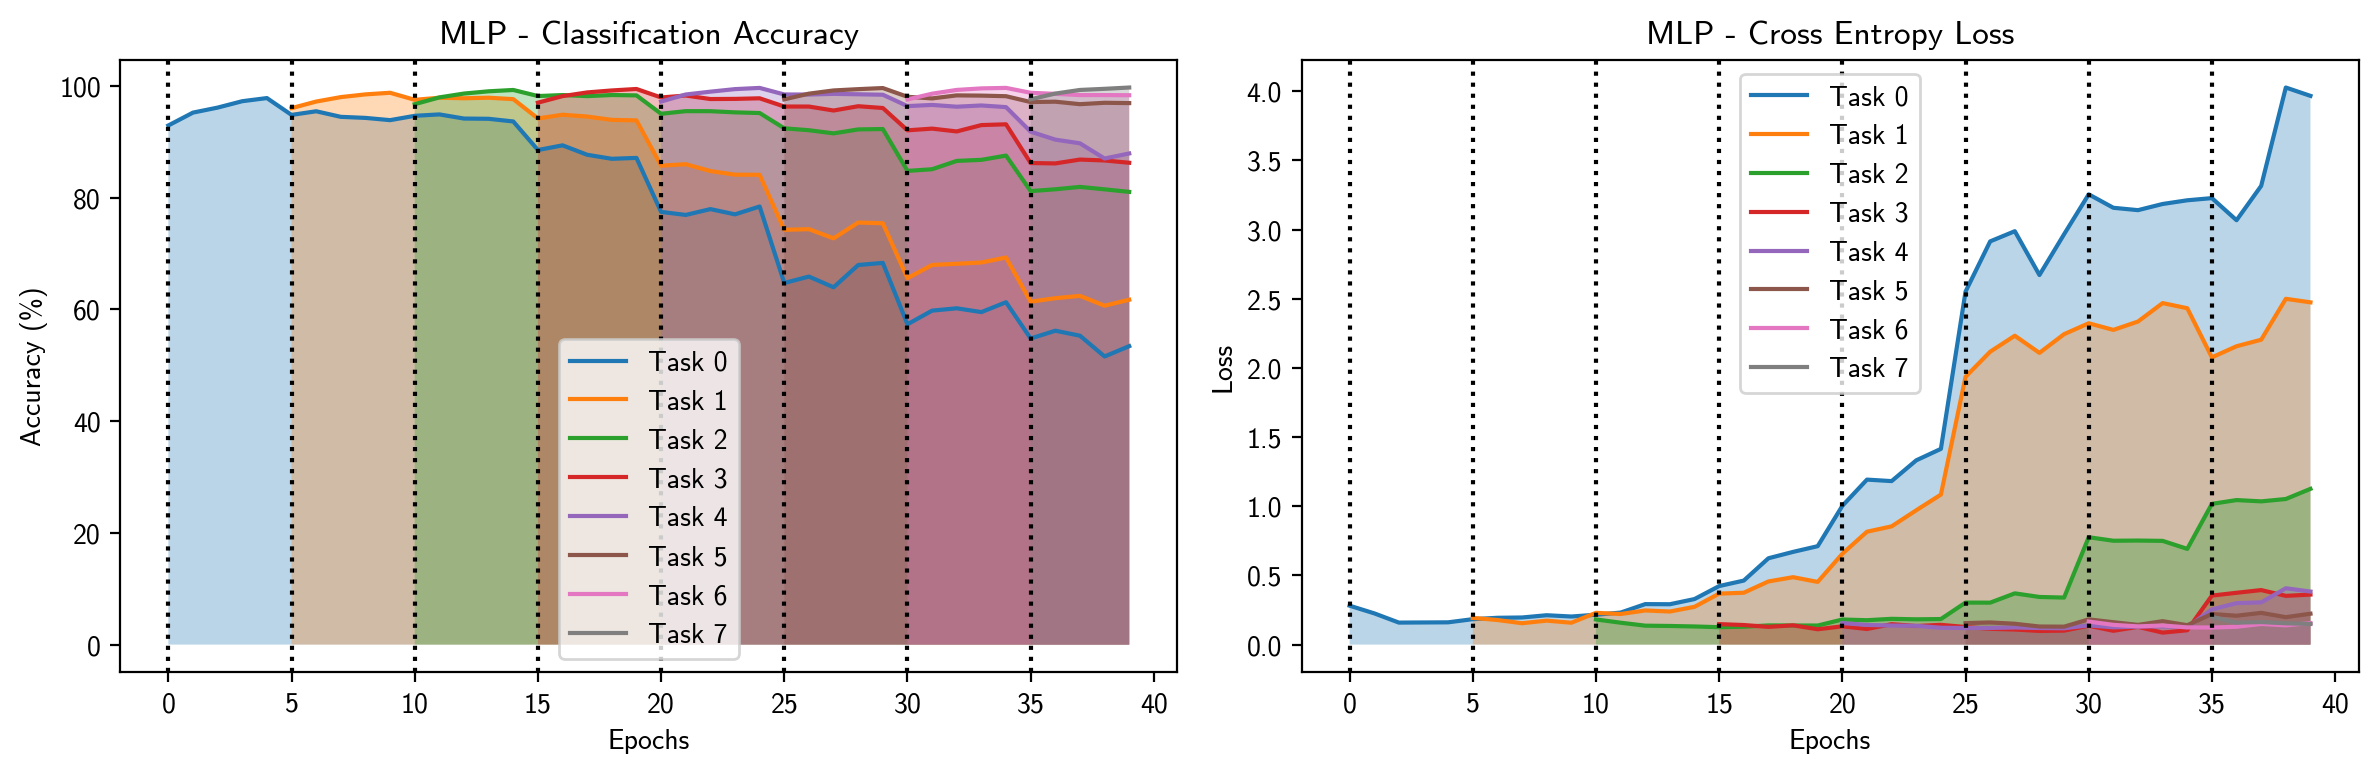

In [50]:
mlp_results = torch.load('mlp_mnist.pt')
mlp_loss, mlp_acc = mlp_results['mlp_loss'], mlp_results['mlp_acc'] 
plot_accuracy_loss(mlp_acc, mlp_loss, title='MLP')

### MLP with Dropout

In [ ]:
torch.manual_seed(0)
mlp = torch.nn.Sequential(nn.Linear(784, 1024), nn.ReLU(), nn.Dropout(0.5), nn.Linear(1024, 512), nn.ReLU(), nn.Dropout(0.5), nn.Linear(512, 256), nn.ReLU(), nn.Dropout(0.5), nn.Linear(256, 10)).cuda()
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-4)
train_loaders, valid_loaders = zip(*[permuted_mnist(permutation=torch.randperm(784), batch_size=100) for _ in range(8)])
mlp_dropout_loss, mlp_dropout_acc = train_mlp(mlp, train_loaders, valid_loaders, optimizer)
torch.save({'mlp_dropout_loss': mlp_dropout_loss, 'mlp_dropout_acc': mlp_dropout_acc}, 'mlp_dropout_mnist.pt')

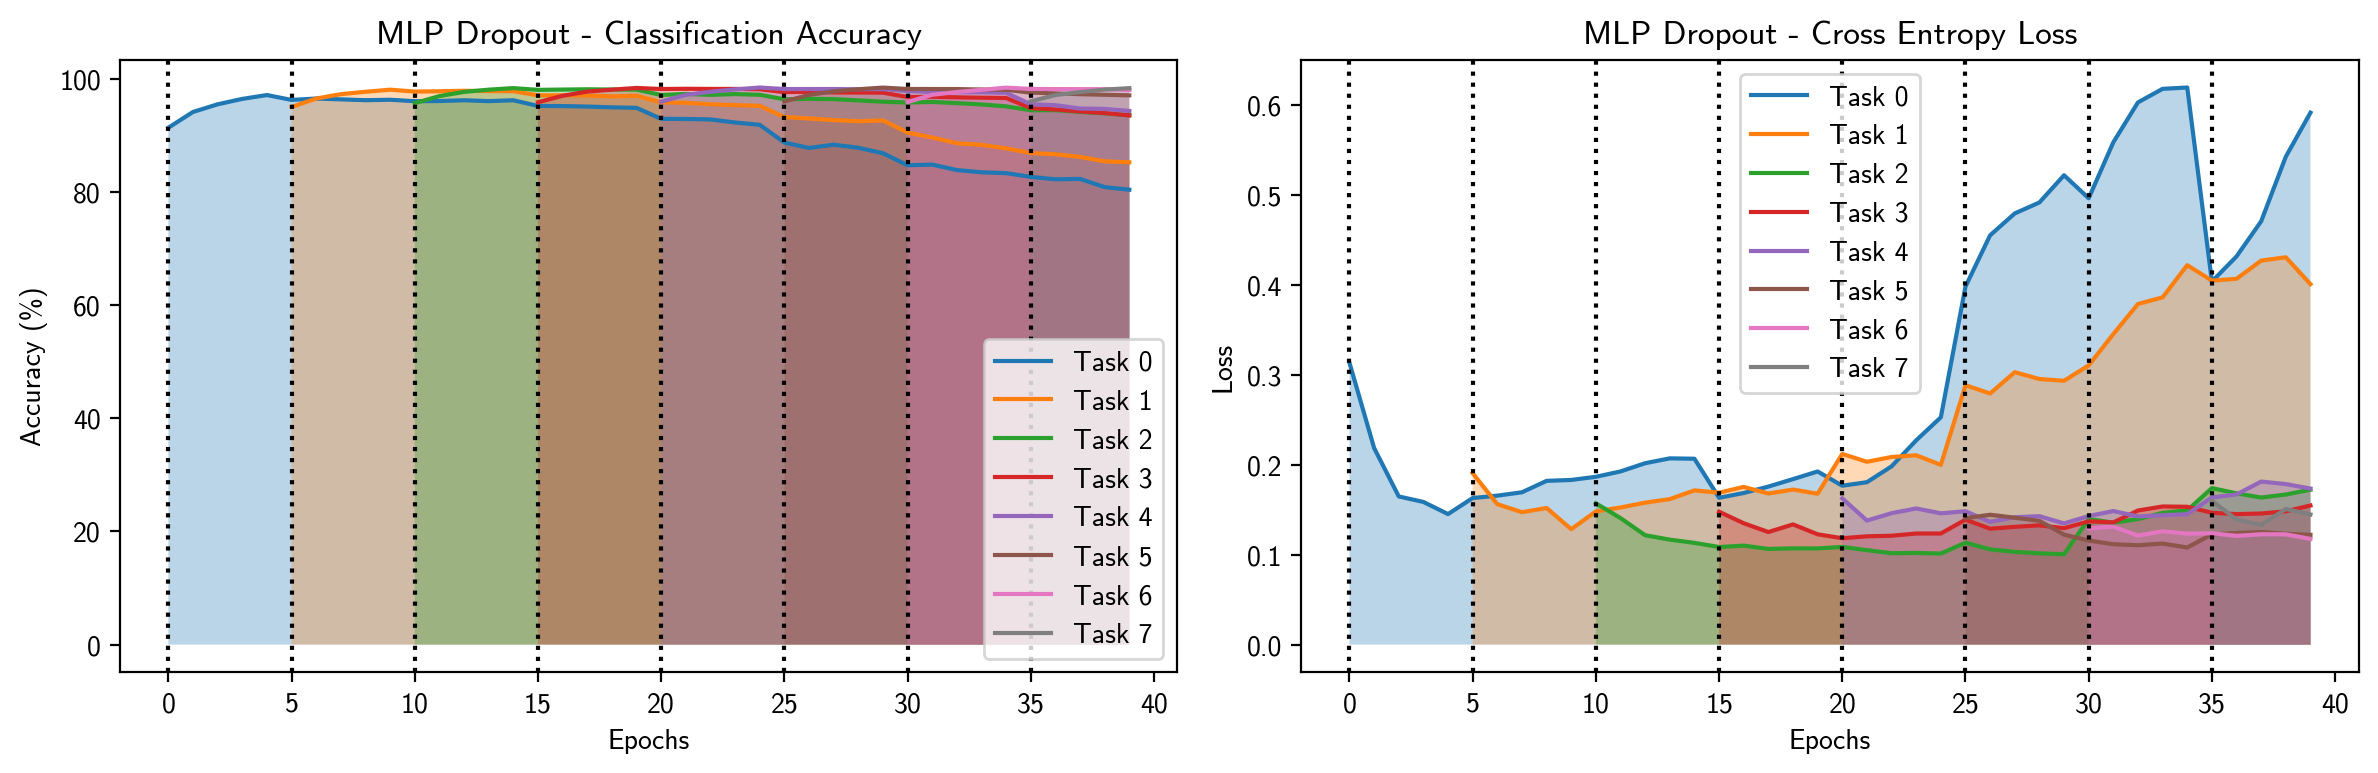

In [36]:
mlp_dropout_results = torch.load('mlp_dropout_mnist.pt')
mlp_dropout_loss, mlp_dropout_acc = mlp_dropout_results['mlp_dropout_loss'], mlp_dropout_results['mlp_dropout_acc'] 
plot_accuracy_loss(mlp_dropout_acc, mlp_dropout_loss, title='MLP Dropout')

### MLP with BatchNorm

In [ ]:
torch.manual_seed(0)
mlp = torch.nn.Sequential(nn.Linear(784, 1024), nn.BatchNorm1d(1024), nn.ReLU(), nn.Linear(1024, 512), nn.BatchNorm1d(512), nn.ReLU(), nn.Linear(512, 256), nn.BatchNorm1d(256), nn.ReLU(), nn.Linear(256, 10)).cuda()
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-4)
train_loaders, valid_loaders = zip(*[permuted_mnist(permutation=torch.randperm(784), batch_size=100) for _ in range(8)])
mlp_bn_loss, mlp_bn_acc = train_mlp(mlp, train_loaders, valid_loaders, optimizer)
torch.save({'mlp_bn_loss': mlp_bn_loss, 'mlp_bn_acc': mlp_bn_acc}, 'mlp_bn_mnist.pt')

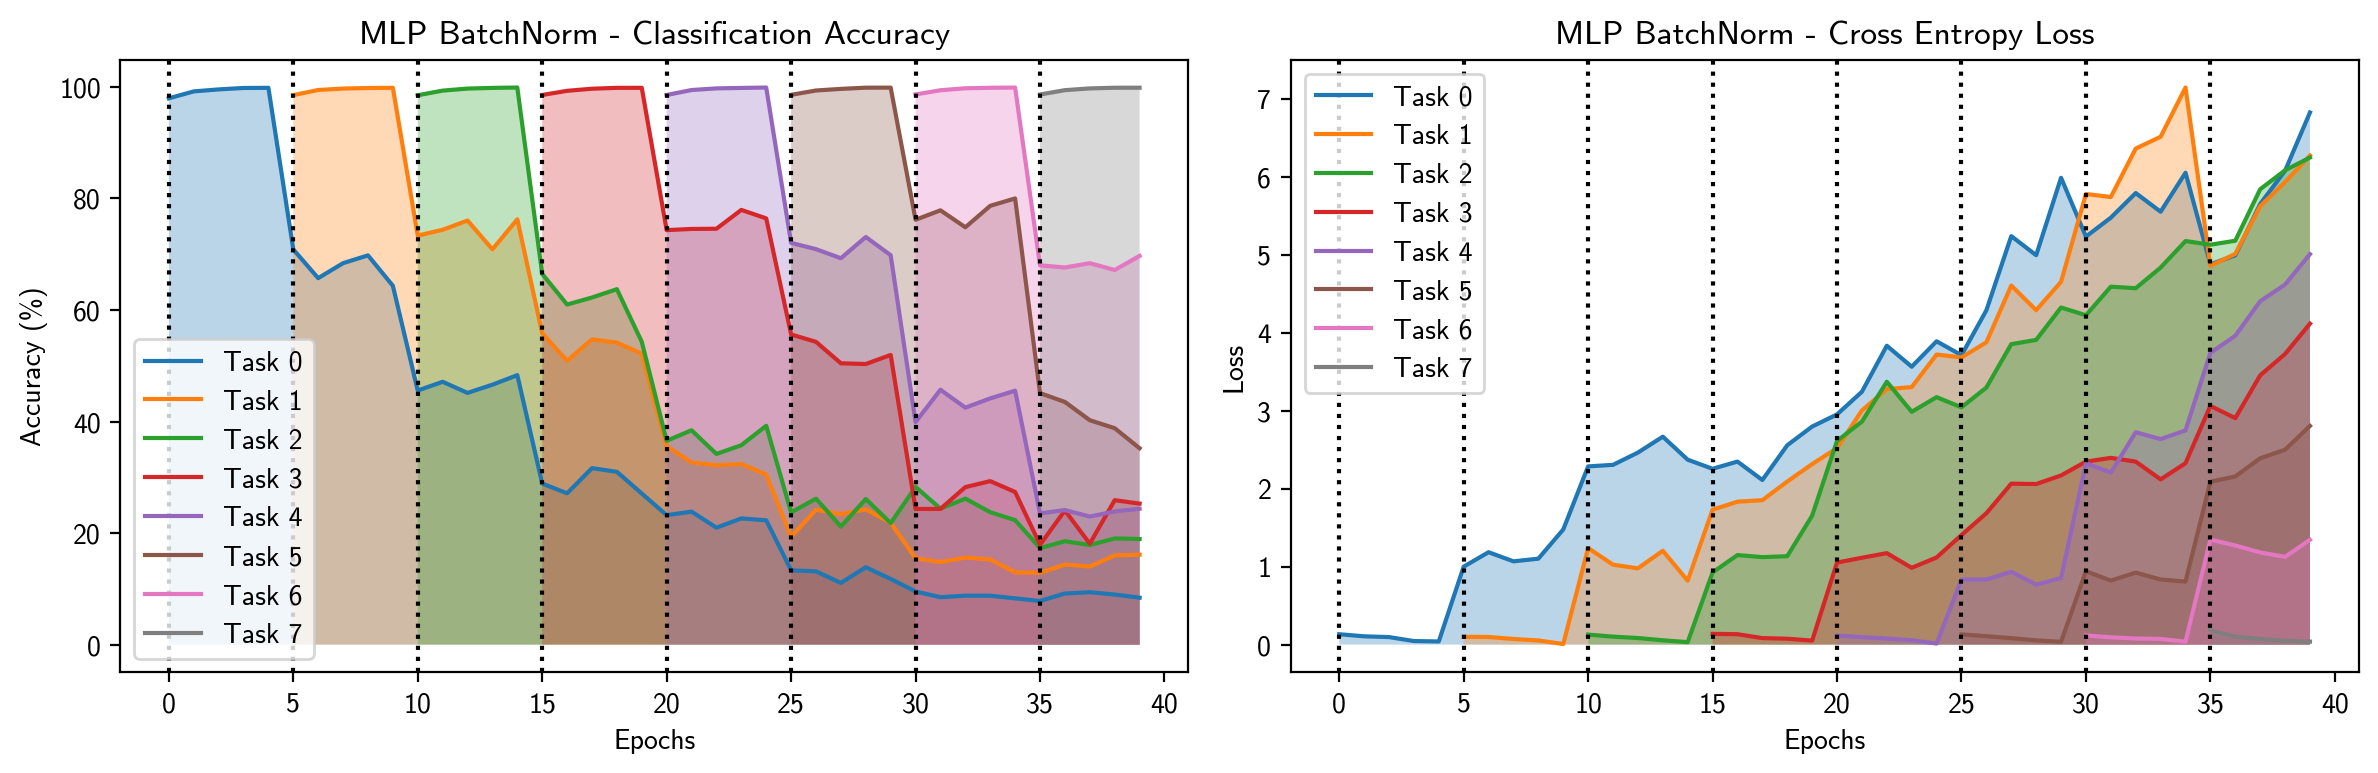

In [25]:
mlp_bn_results = torch.load('mlp_bn_mnist.pt')
mlp_bn_loss, mlp_bn_acc = mlp_bn_results['mlp_bn_loss'], mlp_bn_results['mlp_bn_acc'] 
plot_accuracy_loss(mlp_bn_acc, mlp_bn_loss, title='MLP BatchNorm')

### MLP with Weight Decay

In [ ]:
torch.manual_seed(0)
mlp = torch.nn.Sequential(nn.Linear(784, 1024), nn.ReLU(), nn.Linear(1024, 512), nn.ReLU(), nn.Linear(512, 256), nn.ReLU(), nn.Linear(256, 10)).cuda()
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-4, weight_decay=1e-4)
train_loaders, valid_loaders = zip(*[permuted_mnist(permutation=torch.randperm(784), batch_size=100) for _ in range(8)])
mlp_l2_loss, mlp_l2_acc = train_mlp(mlp, train_loaders, valid_loaders, optimizer)
torch.save({'mlp_l2_loss': mlp_l2_loss, 'mlp_l2_acc': mlp_l2_acc}, 'mlp_l2_mnist.pt')

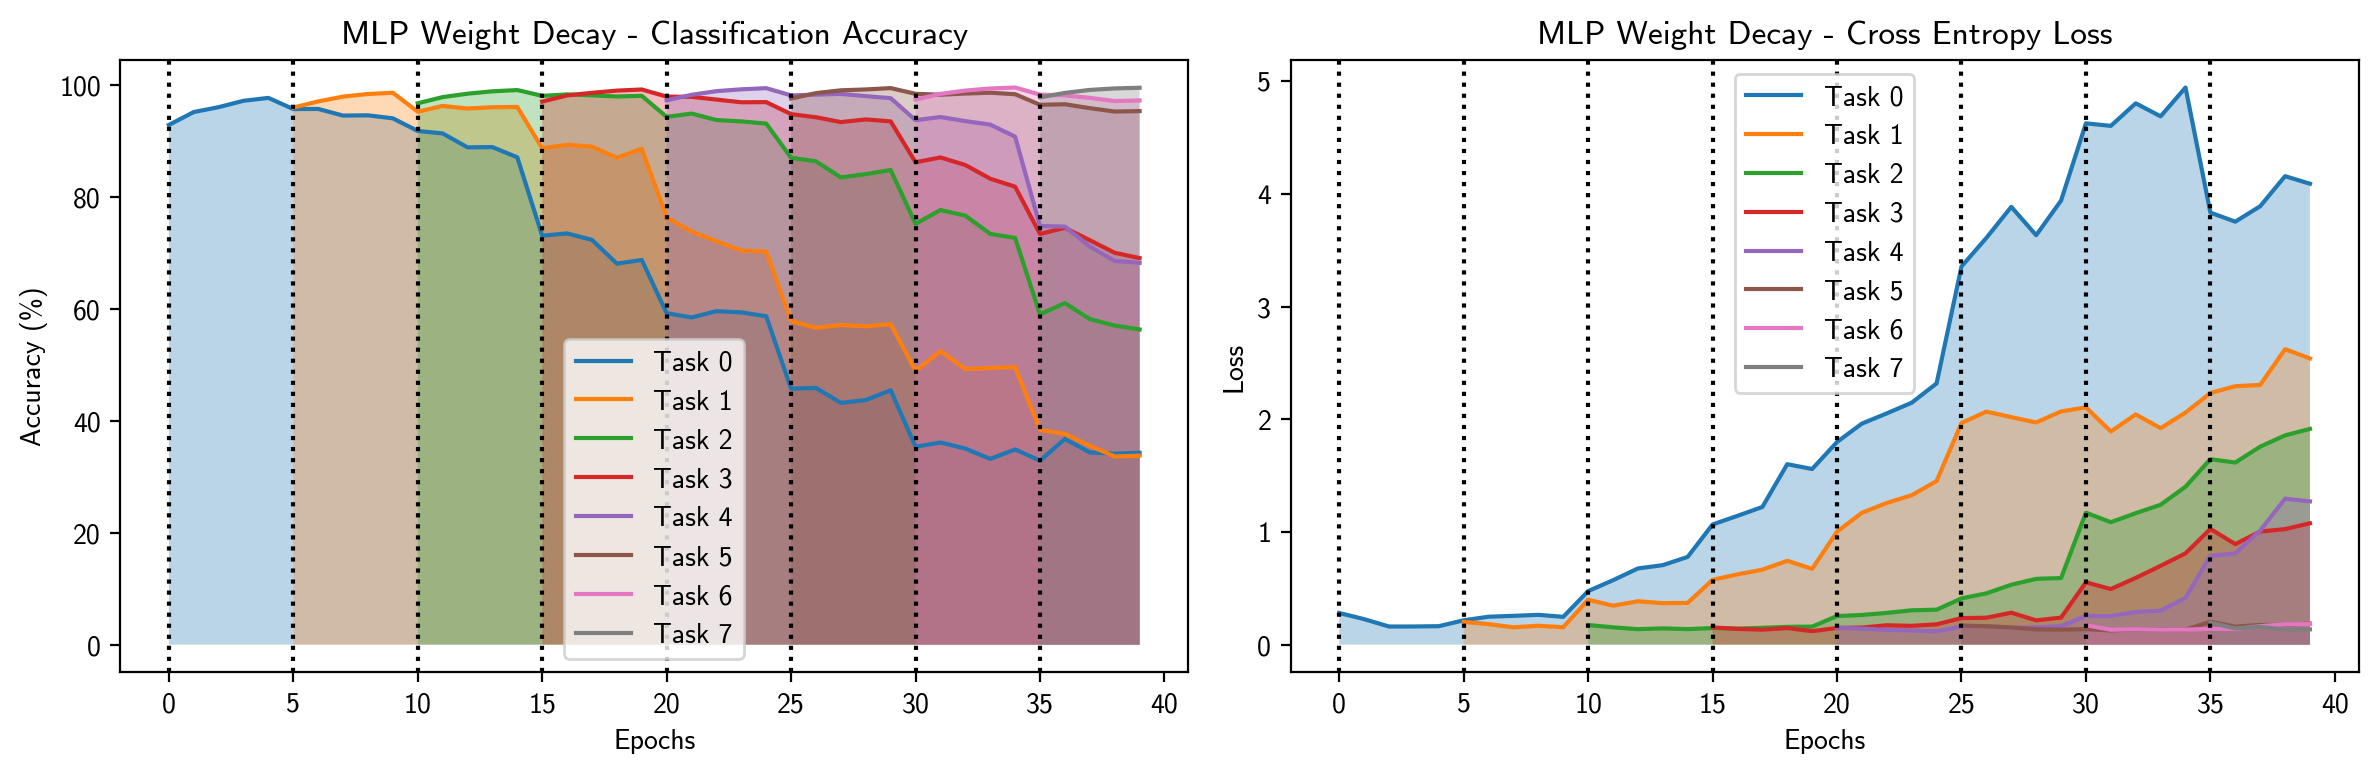

In [27]:
mlp_l2_results = torch.load('mlp_l2_mnist.pt')
mlp_l2_loss, mlp_l2_acc = mlp_l2_results['mlp_l2_loss'], mlp_l2_results['mlp_l2_acc'] 
plot_accuracy_loss(mlp_l2_acc, mlp_l2_loss, title='MLP Weight Decay')

### MLP with Elastic Weight Consolidation

In [ ]:
torch.manual_seed(0)
mlp = torch.nn.Sequential(nn.Linear(784, 1024), nn.ReLU(), nn.Linear(1024, 512), nn.ReLU(), nn.Linear(512, 256), nn.ReLU(), nn.Linear(256, 10)).cuda()
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-4)
train_loaders, valid_loaders = zip(*[permuted_mnist(permutation=torch.randperm(784), batch_size=100) for _ in range(8)])

ewc_loss, ewc_acc = defaultdict(list), defaultdict(list)
prev_params, prev_fisher = None, None

for task_id, train_loader in enumerate(train_loaders):
    for epoch in range(5):
        progress_bar = tqdm(train_loader, desc='Task {} - Train Epoch {:03d}'.format(task_id, epoch), leave=False)
        for batch_id, (images, labels) in enumerate(progress_bar):
            images, labels = images.cuda(), labels.cuda()
            nll = F.cross_entropy(input=mlp(images), target=labels)
            ewc = 0.5 * 100000 * sum((prev_fisher[name] * (param - prev_params[name]) ** 2).sum() for name, param in mlp.named_parameters()) if task_id > 0 else torch.tensor(0.)
            loss = nll + ewc
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            progress_bar.set_postfix({'loss': '{:.3f}'.format(loss.item()), 'nll': '{:.3f}'.format(nll.item()), 'ewc': '{:.3f}'.format(ewc.item())})

        for prev_task_id, valid_loader in enumerate(valid_loaders[:task_id + 1]):
            correct, total = 0, 0
            progress_bar = tqdm(valid_loader, desc='Task {} - Test Task {}'.format(task_id, prev_task_id), leave=True)
            for batch_id, (images, labels) in enumerate(progress_bar):
                images, labels = images.cuda(), labels.cuda()
                logits = mlp(images)
                loss = F.cross_entropy(input=logits, target=labels)
                preds = logits.argmax(dim=1, keepdim=True)
                correct += preds.eq(labels.view_as(preds)).sum().item()
                total += len(images)
                progress_bar.set_postfix({'loss': '{:.3f}'.format(loss.item()), 'accuracy': '{:.3f}'.format(1.0 * correct / total)})

            ewc_loss[prev_task_id].append(loss.item())
            ewc_acc[prev_task_id].append(1.0 * correct / total)

    prev_params = {name: param.detach().clone() for name, param in mlp.named_parameters()}
    prev_fisher = {name: torch.zeros_like(param) for name, param in mlp.named_parameters()}
    nlls = [F.cross_entropy(mlp(images.cuda()), labels.cuda(), reduction='none') for images, labels in itertools.islice(train_loader, 0, 5)]
    nlls = torch.cat(nlls).unbind()
    for nll in nlls:
        mlp.zero_grad()
        nll.backward(retain_graph=True)
        for name, param in mlp.named_parameters():
            prev_fisher[name] += param.grad.detach() ** 2
    prev_fisher = {name: value / len(nlls) for name, value in prev_fisher.items()}
    
torch.save({'ewc_loss': ewc_loss, 'ewc_acc': ewc_acc}, 'ewc_mnist.pt')

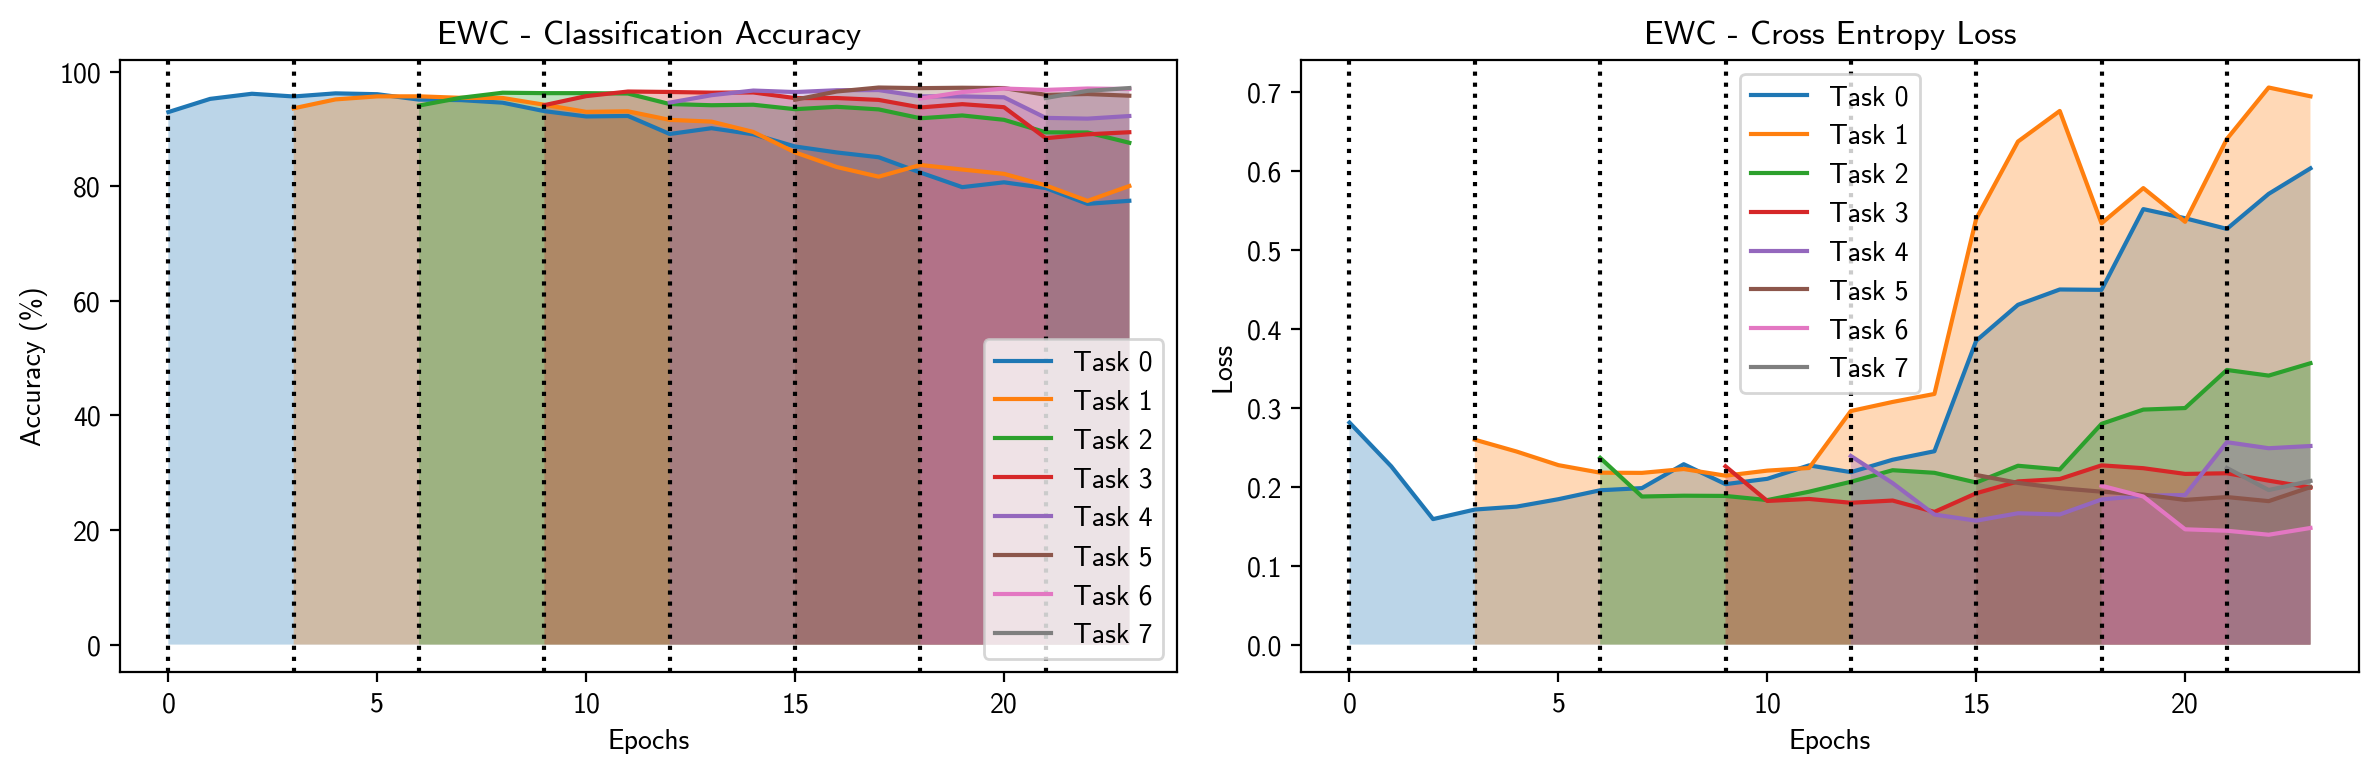

In [12]:
ewc_results = torch.load('ewc_mnist.pt')
ewc_loss, ewc_acc = ewc_results['ewc_loss'], ewc_results['ewc_acc'] 
plot_accuracy_loss(ewc_acc, ewc_loss, title='EWC', num_epochs_per_task=3)

In [2]:
from IPython.core.display import HTML
HTML(open('../css/custom.css', 'r').read())